In [1]:
# Smarter Circuits #
import sys
sys.path.append('../')


import imagePreprocessing as ip
import graphGeneration as gg
import cuircitGeneration as cg
import componentClassification as cc
import matplotlib.pyplot as plt
import cv2
import lib.utils as utils
import os
import random
import string

C:\Users\Christoph Weberbauer\AppData\Local\Programs\Python\Python39\lib\site-packages\drawSvg\raster.py:18: RuntimeWarning: Failed to import CairoSVG. drawSvg will be unable to output PNG or other raster image formats. See https://github.com/cduck/drawSvg#prerequisites for more details.
Original OSError: no library called "cairo-2" was found
no library called "cairo" was found
cannot load library 'C:\GTK\bin\libcairo-2.dll': error 0xc1
cannot load library 'libcairo.so.2': error 0x7e
cannot load library 'libcairo.2.dylib': error 0x7e
cannot load library 'libcairo-2.dll': error 0x7f
  warnings.warn(msg, RuntimeWarning)


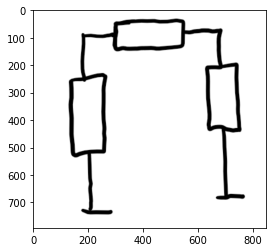

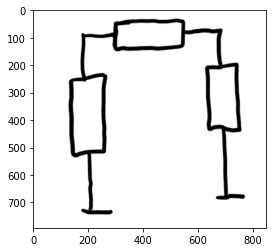

In [2]:
name = "5.png"

image = utils.loadImage(path="./../resources/testImages",name=name, resize=(350,None))

colorImage = utils.loadImage(path="./../resources/testImages",name=name, resize=(350,None), color=True)

plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(colorImage)

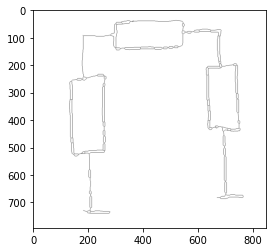

In [3]:
preprocessedImage = ip.preprocessImage(image)
utils.saveImage(name="preprocessed.png", image=preprocessedImage)

plt.imshow(preprocessedImage, cmap='gray')

In [4]:
#class_names = os.listdir('./../trainData')
#
#for class_name in class_names:
#    data = os.listdir('./trainData/{class_name}'.format(class_name=class_name))

def generateTrainData(boundingBoxes, image):
    counter = []
    for box in boundingBoxes:
        component = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        component = cv2.resize(component, (32,32), interpolation = cv2.INTER_AREA)
        utils.saveImage(path='./../resources/trainData/')
        #utils.saveImage(name="{i}.png".format(i=''.join(random.choice(string.ascii_lowercase) for i in range(10))), image=component)

end reached


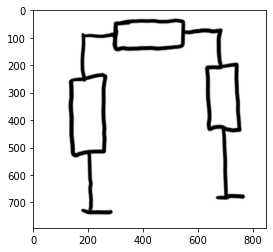

In [5]:
graph = gg.generateGraph(preprocessedImage)
components = gg.getComponents(graph)
#generateTrainData(boundingBoxes, image)

def drawRect(image,boundingBox,color):
    corner1 = boundingBox[0]
    corner2 = boundingBox[1]
    startX = corner1[0]
    startY = corner1[1]

    endX = corner2[0]
    endY = corner2[1]

    for x in range(startX,endX):
        image[startY][x] = color
        image[endY][x] = color

    for y in range(startY,endY):
        image[y][startX] = color
        image[y][endX] = color

    return image


for comp in components:
    drawRect(colorImage,comp[0],(255,0,0))
#colorImage = cv2.cvtColor(255-colorImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorImage,interpolation="bilinear")

In [6]:
cc.loadModel()

predictions = []

for comp in components:
    box = comp[0]
    matches = comp[1]
    buildingType = cc.predict(box,image)[0]
    rot = cc.predict(box,image)[1]
    predictions.append((box,matches,buildingType,rot))
print(len(predictions))

0


inductor -> blue
resistor -> green
capacitor -> red
ground -> purple


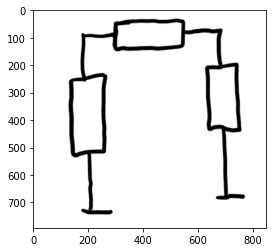

In [7]:
for i in range(0, len(predictions)):
    colorImage = utils.drawArrow(colorImage,predictions[i][0],predictions[i][3],[255,0,0])
    if predictions[i][2] == "inductor":
        colorImage = utils.drawRect(colorImage,predictions[i][0],[255,0,0])
    elif predictions[i][2] == "resistor":
        colorImage = utils.drawRect(colorImage,predictions[i][0],[0,255,0])
    elif predictions[i][2] == "capacitor":
        colorImage = utils.drawRect(colorImage,predictions[i][0],[0,0,255])
    elif predictions[i][2] == "ground":
        colorImage = utils.drawRect(colorImage,predictions[i][0],[255,0,255])

print("inductor -> blue")
print("resistor -> green")
print("capacitor -> red")
print("ground -> purple")


utils.saveImage(name="boundingBoxes.png", image=colorImage, color=True)
colorImage = cv2.cvtColor(colorImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorImage)

In [8]:
cg.createLTSpiceFile(predictions,graph,"./out.asc")

AttributeError: 'NoneType' object has no attribute 'ed'